CheckpointManager initialized:  /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2
No checkpoint found.
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...: 100%|██████████| 100/100 [00:00<00:00, 1004.27it/s]


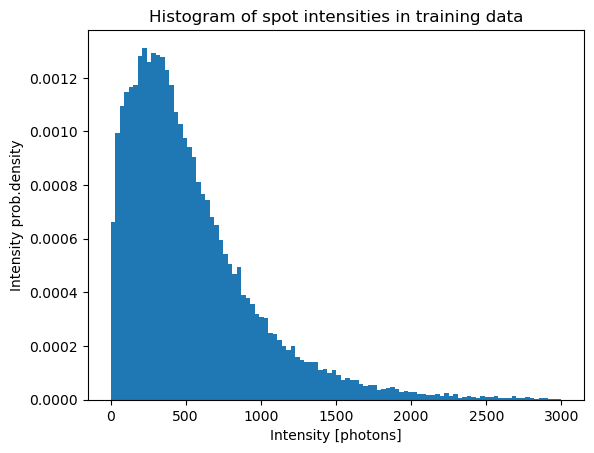

In [1]:
import smlmtorch.util.progbar
# set False if your jupyter notebook does not support javascript plugins
smlmtorch.util.progbar.USE_AUTO_TQDM = False 

import numpy as np 
import torch
import matplotlib.pyplot as plt
from smlmtorch import config_dict
from smlmtorch.nn.sf_model import SFLocalizationModel
from smlmtorch.nn.simulate import SimulatedSMLMDataset, RandomSpotDataset
from smlmtorch.nn.simulate.psf import Gaussian2DPSF
from smlmtorch.nn.model_trainer import LocalizationModelTrainer
from smlmtorch.ui import image_view
from smlmtorch.nn.benchmark.compare_crlb import CRLBPlotGenerator
import os

bg_mean = 5
device = 'cuda:1'
NI = 6
tio = 2
L = 64

config = config_dict(
    model = dict(
        enable_readnoise = False,
        enable3D = False,
        unet_shared_features=[L, L*2], 
        unet_combiner_features=[L, L*2, L*4],
        ie_input_features=32, # number of features going from combiner to IE
        unet_batch_norm = True,
        input_scale = 0.01, # get pixel values into useful range
        input_offset = 3,
        unet_combiner_output_features = 256,
        output_head_features = 48,
        num_intensities=NI,
        max_bg=100,
        max_intensity=20000,
        xyz_scale=[1.1,1.1,1],
        unet_intensity_features=[L, L*2, L*4],
        output_intensity_features=32,
        use_on_prob=False
    ),
    loss = dict(
        gmm_components=0,
        count_loss_weight=0.01,
        track_intensities_offset = tio
    ),
    optimizer_type = 'Lion',
    optimizer = dict(
        lr = 2e-5,
        weight_decay = 0.01
    ),
    #clip_grad_norm_ = dict( max_norm=0.03, norm_type=2 ),
    lr_scheduler = dict(step_size=30, gamma=0.5),
    train_size = 8*1024,
    test_size = 1024,
    batch_size = 6,

    simulation = dict(
        num_frames = 32,
        img_shape=(32,32),
        #num_spots = 200,
        #max_spots = 40,
        #k_on = 0.05, # should change to density and mean-on-time
        #k_off = 0.15,
        z_range = (-0.5,0.5),
        density_um2 = 1.5,
        pixelsize_nm = 100,
        mean_on_time = 6,
        
        track_intensities = NI,
        track_intensities_offset = tio,
        intensity_distr = 'log-normal',
        intensity_mode = 400,
        #intensity_sigma = 500,
        intensity_mean = 600,
        intensity_mean_min = 50,
        intensity_mean_max = 10000,
        intensity_fluctuation_std = 0.5, # I_frame = I_spot * (1 + fluctuation * randn())
        bg_max = 20,
        bg_min = 0.5,
        render_args = dict(
            read_noise_mean = 0.5,
            read_noise_std = 1
        ),
        psf = dict(
            type = 'Gaussian2D',
            sigma = [1.3, 1.3],
        )
    ),
    benchmark = dict(
        prob_threshold=0.5, 
        match_distance_px=3,
        kdeplot_params =['N0', 'N5'],
        render_frame_offset=tio
    )
)

# x,y,z,I,start,end,bg
savedir = f'models/sf_conv_g1.3_tio2_L{L}_2'
if os.path.exists('scripts'):
    savedir = 'scripts/' + savedir

trainer = LocalizationModelTrainer(config, SFLocalizationModel, device, 
    save_dir=savedir, load_previous_model=True)
#%%
ds = trainer.data_generator.generate(100)
active = ds.spots_ds.spots[:,:,:,0]>0
intensities = ds.spots_ds.spots[:,:,:,1][active]

plt.figure()
plt.hist(intensities, bins=100, range=[0,3000],density=True)
plt.title('Histogram of spot intensities in training data')
plt.ylabel('Intensity prob.density')
plt.xlabel('Intensity [photons]')
plt.savefig(trainer.save_dir+"/intensities_histogram.svg")

k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 0 [1364/1365], Train Loss: 4.3991e+02: 100%|██████████| 1365/1365 [09:42<00:00,  2.34it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


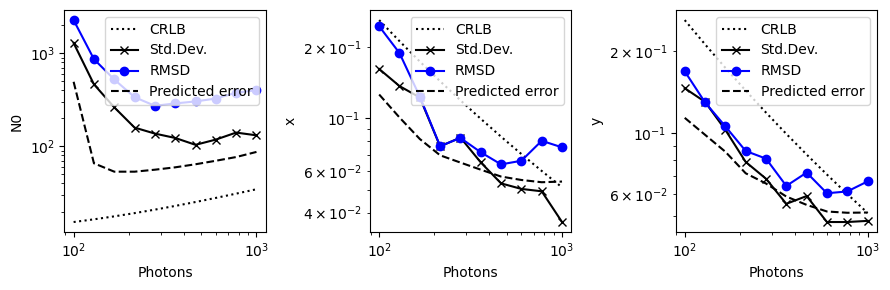

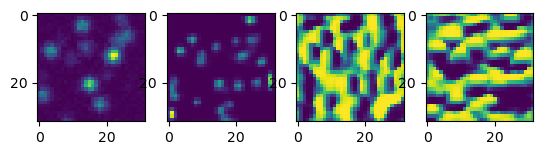

Writing benchmark info to tensorboard
Epoch 0 [1364/1365], Train Loss: 5.8880e+02. Test Loss: 4.8035e+02
saving checkpoint
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  96%|█████████▌| 8840/9216 [00:04<00:00, 2075.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 4 [1364/1365], Train Loss: 3.3746e+02: 100%|██████████| 1365/1365 [09:40<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


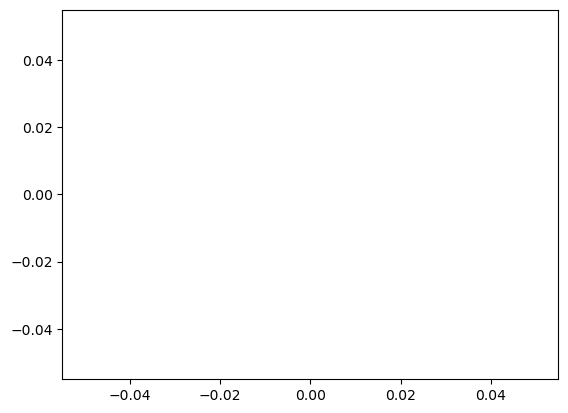

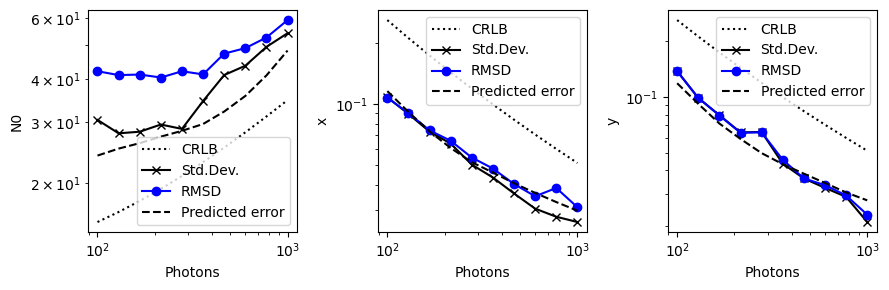

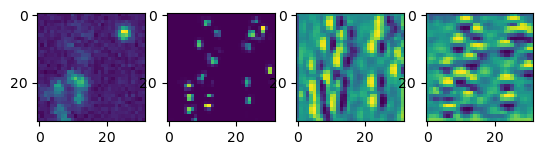

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 4 [1364/1365], Train Loss: 3.7778e+02. Test Loss: 3.6722e+02
saving checkpoint
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 5 [455/1365], Train Loss: 3.7387e+02:  33%|███▎      | 456/1365 [03:13<06:27,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 9 [1364/1365], Train Loss: 3.5439e+02: 100%|██████████| 1365/1365 [09:40<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


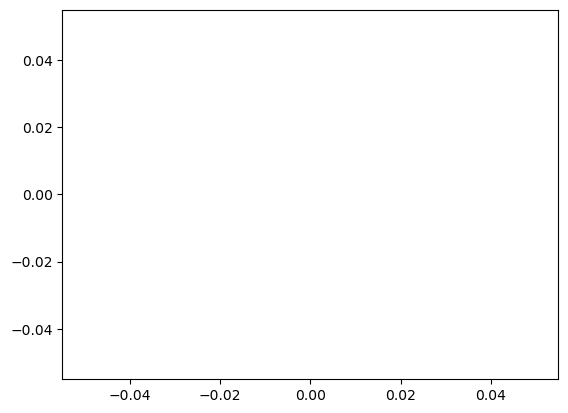

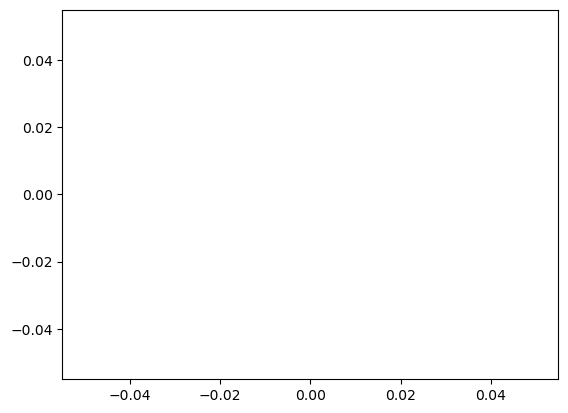

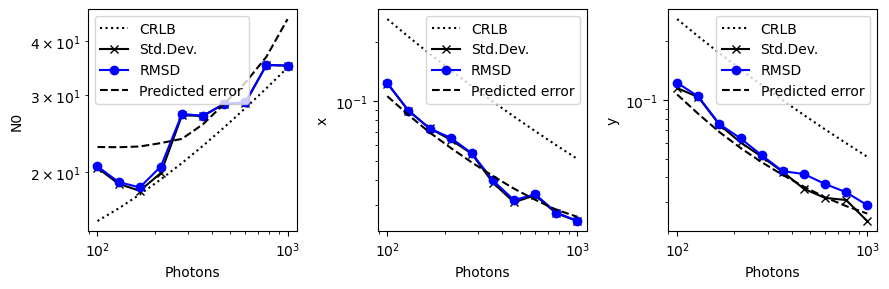

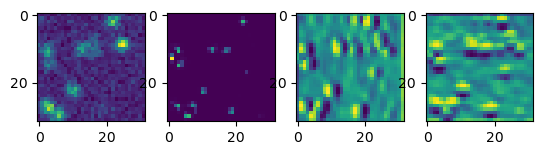

Writing benchmark info to tensorboard
Epoch 9 [1364/1365], Train Loss: 3.4953e+02. Test Loss: 3.4028e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  72%|███████▏  | 6616/9216 [00:03<00:01, 2120.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 14 [1167/1365], Train Loss: 2.6641e+02:  86%|████████▌ | 1169/1365 [08:16<01:23,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 18 [1364/1365], Train Loss: 3.3497e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


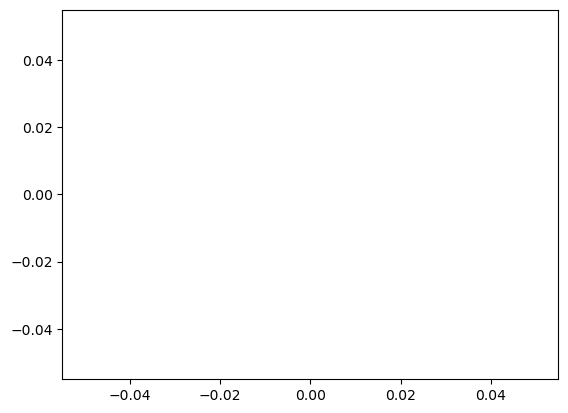

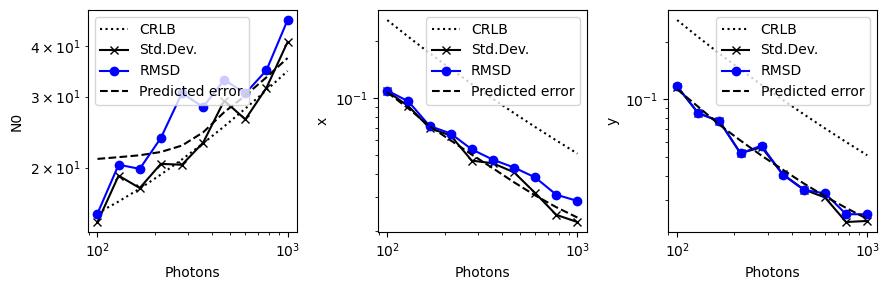

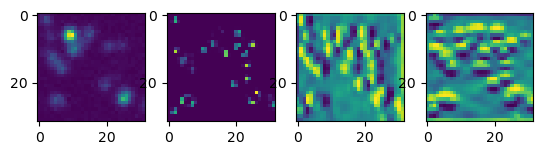

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 18 [1364/1365], Train Loss: 3.3304e+02. Test Loss: 3.3267e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 19 [543/1365], Train Loss: 3.2650e+02:  40%|███▉      | 545/1365 [03:50<05:49,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 23 [1364/1365], Train Loss: 3.0311e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


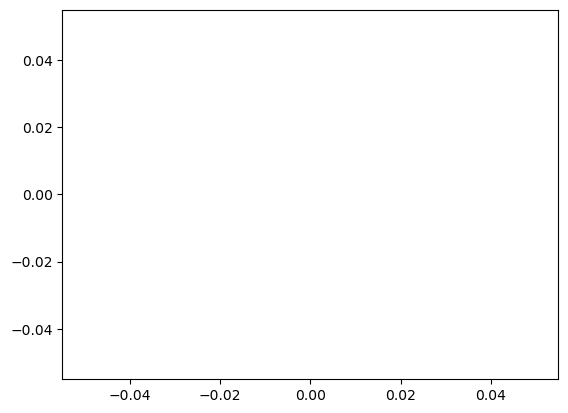

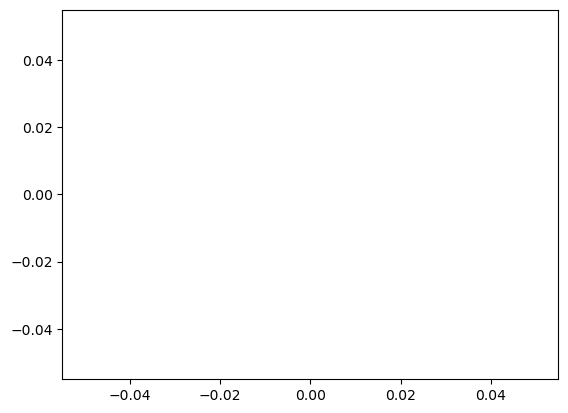

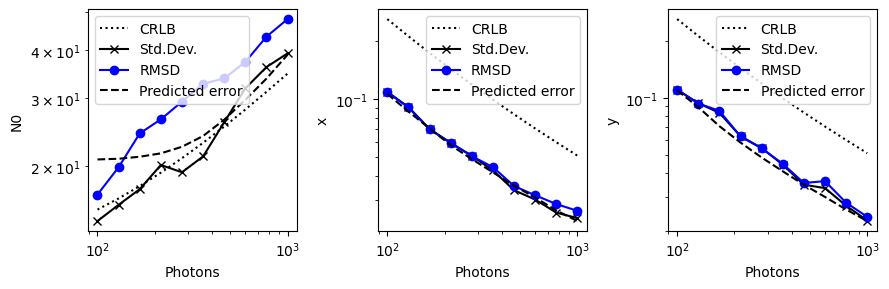

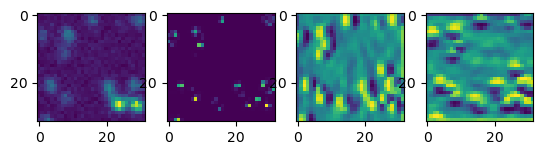

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 23 [1364/1365], Train Loss: 3.2798e+02. Test Loss: 3.2963e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  69%|██████▉   | 6368/9216 [00:03<00:01, 2094.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 27 [1364/1365], Train Loss: 3.0148e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


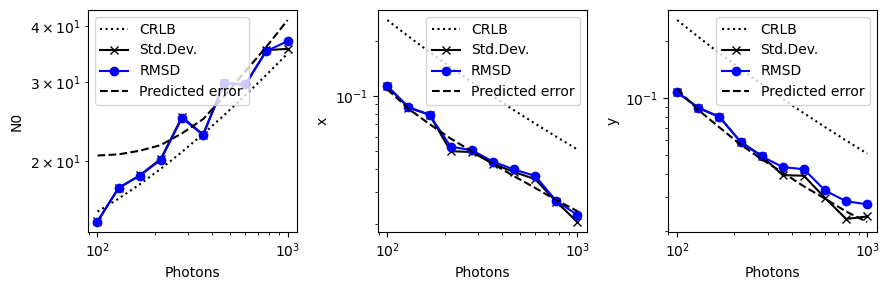

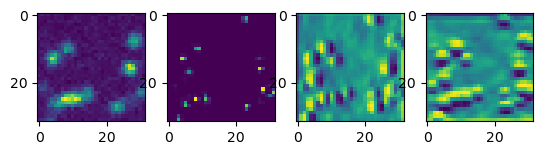

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 27 [1364/1365], Train Loss: 3.2445e+02. Test Loss: 3.2014e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  41%|████      | 3752/9216 [00:01<00:02, 2078.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 28 [1071/1365], Train Loss: 3.2209e+02:  79%|███████▊  | 1073/1365 [07:35<02:04,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 32 [837/1365], Train Loss: 3.2002e+02:  61%|██████▏   | 838/1365 [05:55<03:44,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending outpu

Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


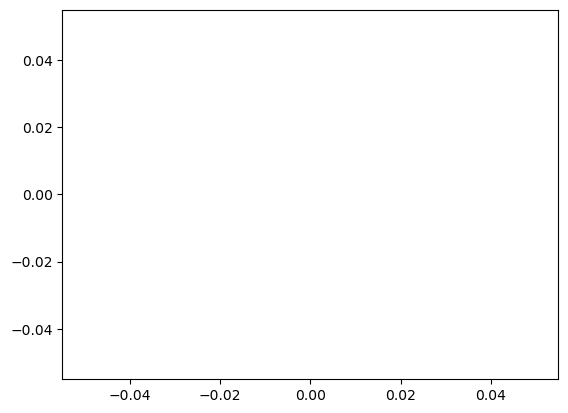

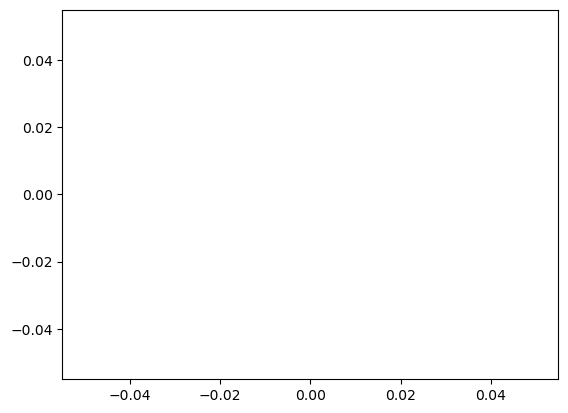

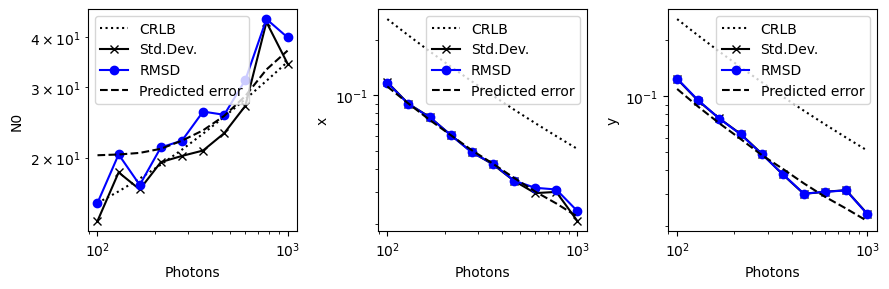

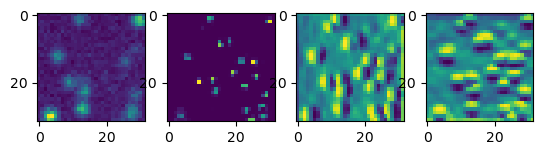

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 36 [1364/1365], Train Loss: 3.1484e+02. Test Loss: 3.0936e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 37 [29/1365], Train Loss: 3.2540e+02:   2%|▏         | 30/1365 [00:12<09:16,  2.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 37 [1364/1365], Train Loss: 3.2535e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


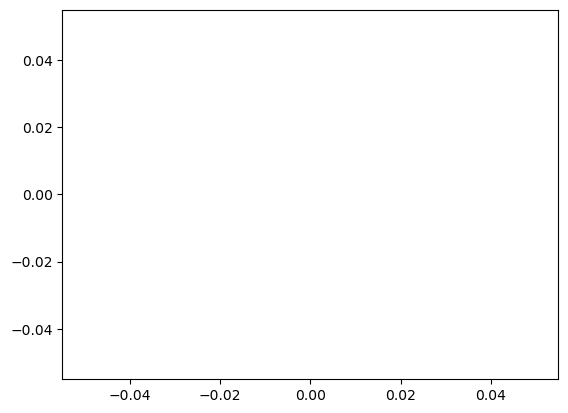

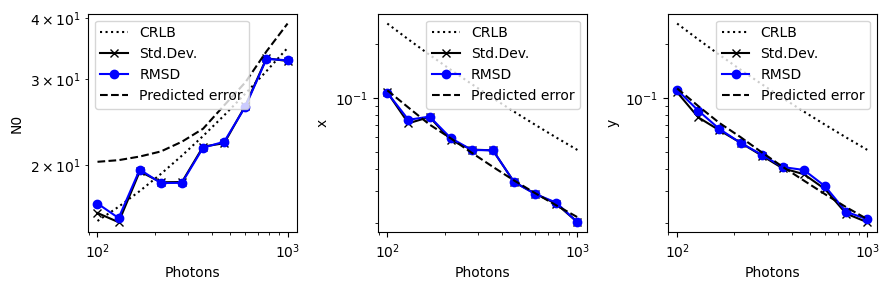

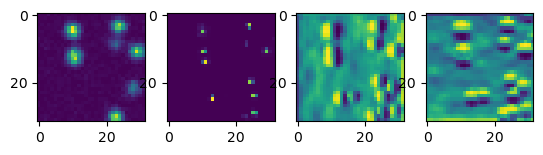

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 37 [1364/1365], Train Loss: 3.1456e+02. Test Loss: 3.0663e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:   5%|▌         | 464/9216 [00:00<00:04, 1998.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 41 [1138/1365], Train Loss: 2.7890e+02:  83%|████████▎ | 1139/1365 [08:04<01:36,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 42 [372/1365], Train Loss: 2.6214e+02:  27%|██▋       | 374/1365 [02:38<07:00,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output

Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


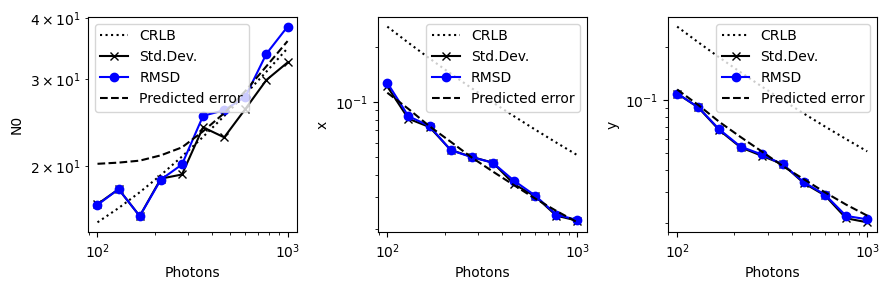

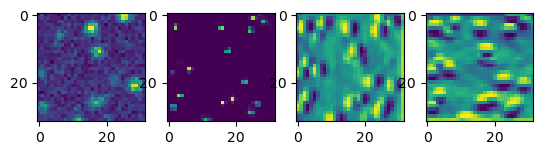

Writing benchmark info to tensorboard
Epoch 46 [1364/1365], Train Loss: 3.1171e+02. Test Loss: 3.1242e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  64%|██████▍   | 5928/9216 [00:02<00:01, 2088.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 50 [1364/1365], Train Loss: 3.2660e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


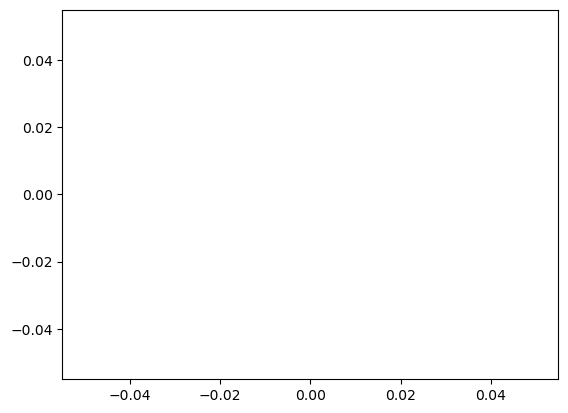

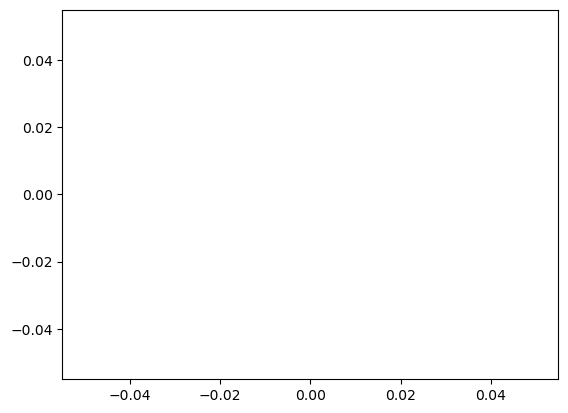

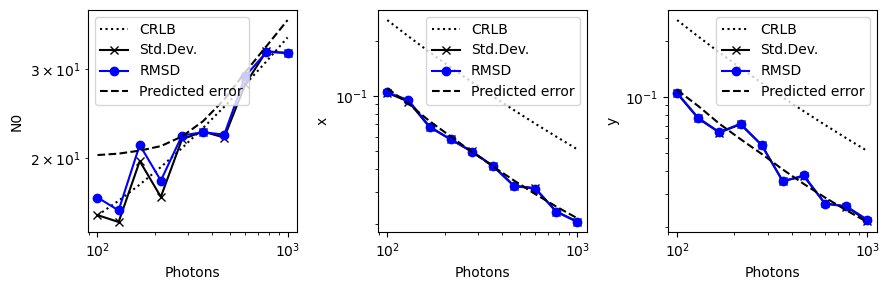

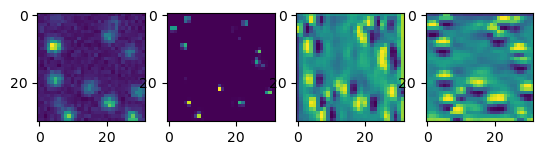

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 50 [1364/1365], Train Loss: 3.1149e+02. Test Loss: 3.0594e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 51 [468/1365], Train Loss: 3.0435e+02:  34%|███▍      | 470/1365 [03:18<06:20,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 54 [1364/1365], Train Loss: 3.2513e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


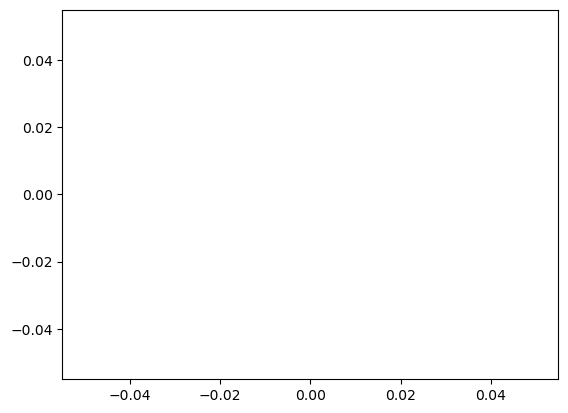

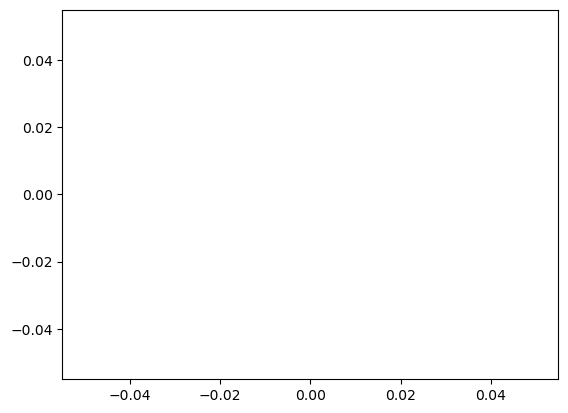

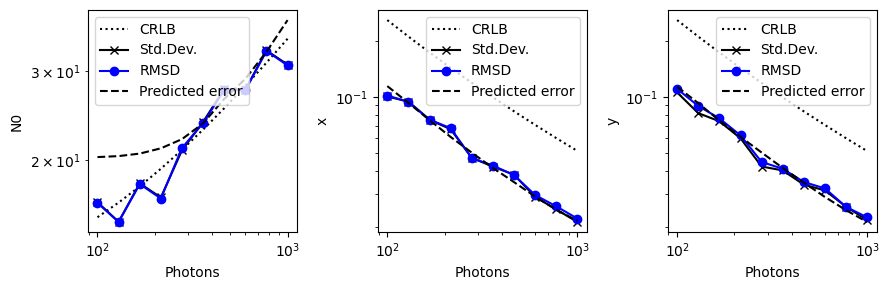

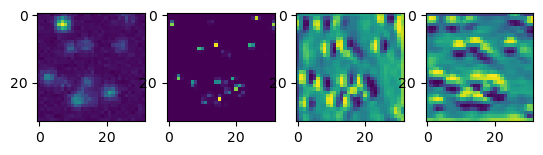

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 54 [1364/1365], Train Loss: 3.0985e+02. Test Loss: 3.0887e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  64%|██████▎   | 5864/9216 [00:02<00:01, 2088.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 55 [1364/1365], Train Loss: 2.9667e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


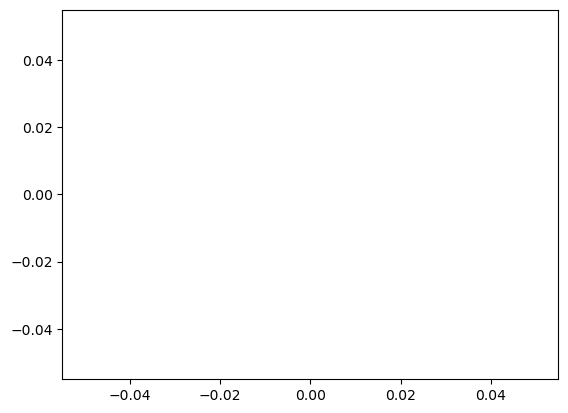

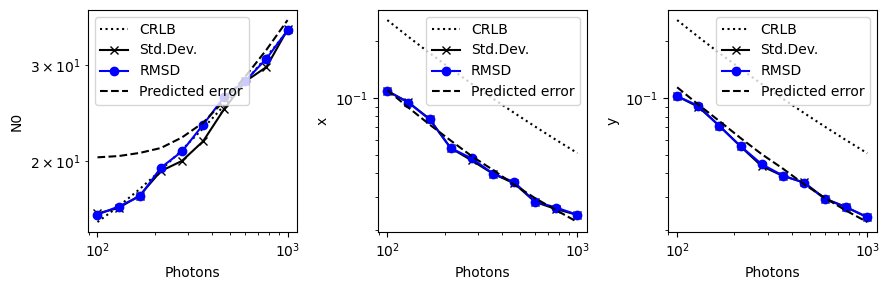

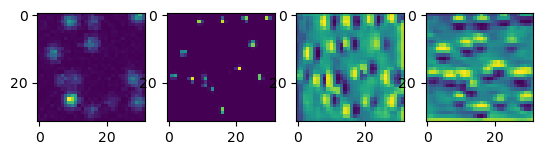

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 55 [1364/1365], Train Loss: 3.0923e+02. Test Loss: 3.1343e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  48%|████▊     | 4424/9216 [00:02<00:02, 2072.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 59 [917/1365], Train Loss: 3.0909e+02:  67%|██████▋   | 919/1365 [06:29<03:09,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 60 [848/1365], Train Loss: 3.0636e+02:  62%|██████▏   | 850/1365 [06:00<03:38,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


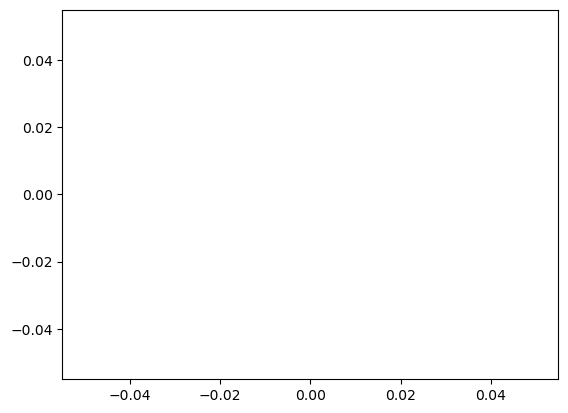

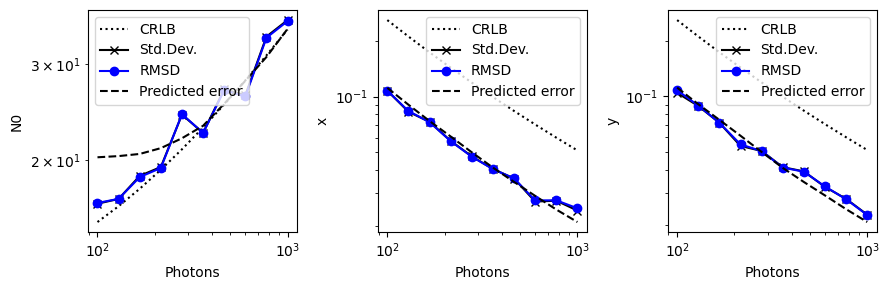

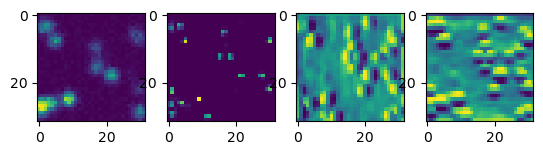

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 64 [1364/1365], Train Loss: 3.0668e+02. Test Loss: 3.0373e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 65 [63/1365], Train Loss: 3.1156e+02:   5%|▍         | 64/1365 [00:26<09:06,  2.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 68 [1124/1365], Train Loss: 2.9294e+02:  82%|████████▏ | 1125/1365 [07:57<01:42,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 69 [1070/1365], Train Loss: 3.3034e+02:  79%|███████▊  | 1072/1365 [07:34<02:04,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporari

Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


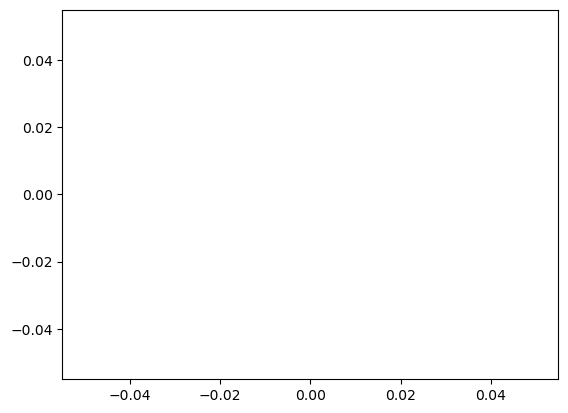

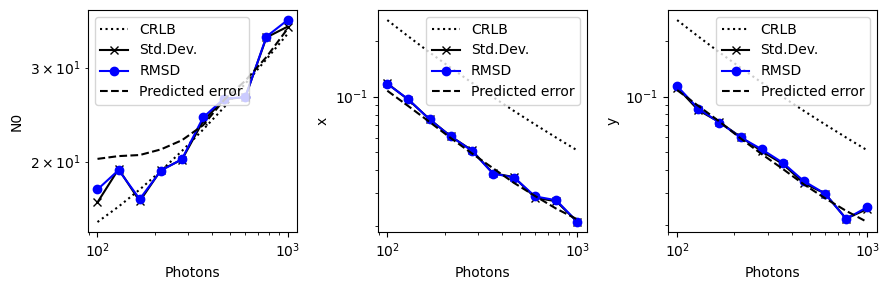

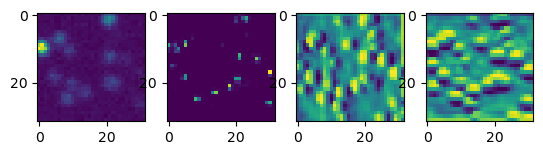

Writing benchmark info to tensorboard
Epoch 73 [1364/1365], Train Loss: 3.0397e+02. Test Loss: 3.0740e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 74 [239/1365], Train Loss: 2.8648e+02:  18%|█▊        | 241/1365 [01:41<07:56,  2.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 77 [1364/1365], Train Loss: 3.1046e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


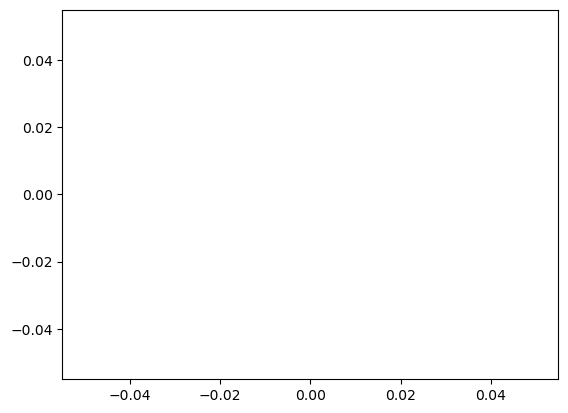

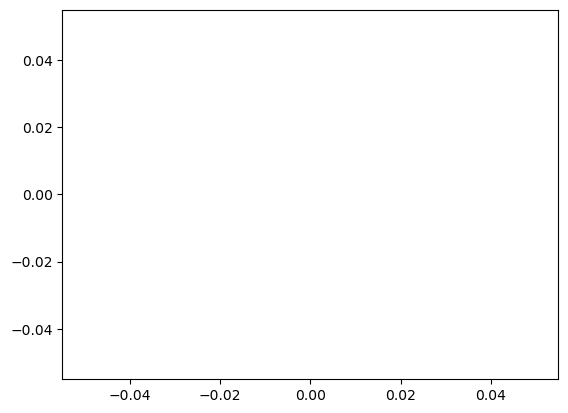

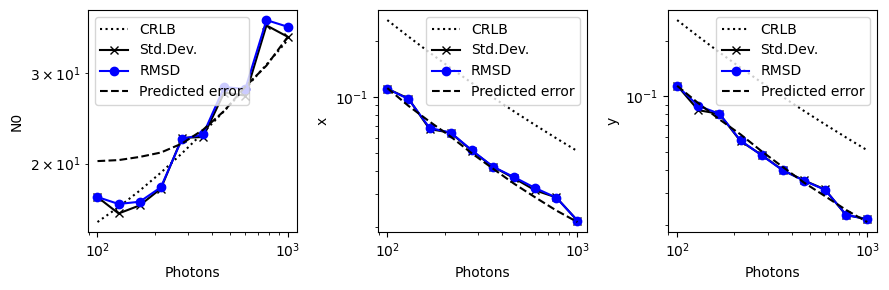

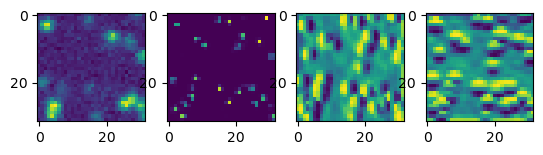

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 77 [1364/1365], Train Loss: 3.0501e+02. Test Loss: 3.0377e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  21%|██        | 1952/9216 [00:00<00:03, 2122.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 78 [1364/1365], Train Loss: 3.4396e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


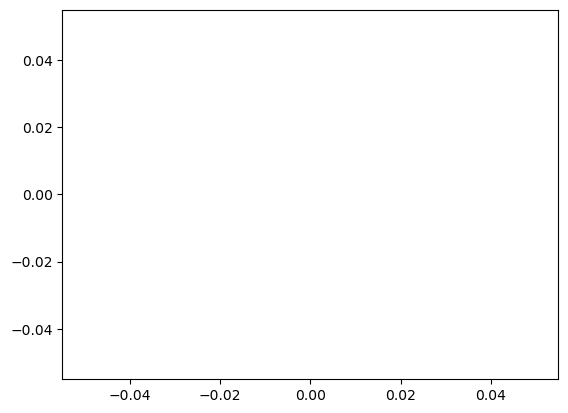

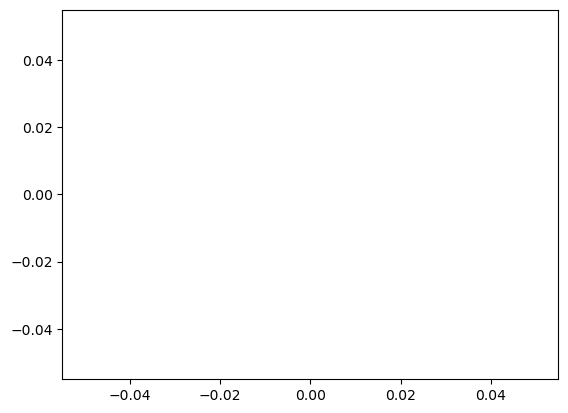

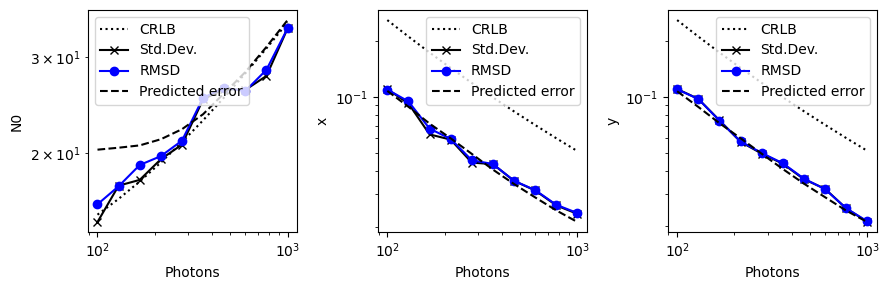

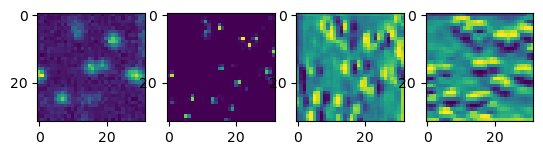

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 78 [1364/1365], Train Loss: 3.0474e+02. Test Loss: 3.0350e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  11%|█         | 968/9216 [00:00<00:04, 1966.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 82 [573/1365], Train Loss: 3.5357e+02:  42%|████▏     | 574/1365 [04:03<05:35,  2.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 82 [1364/1365], Train Loss: 3.0523e+02. Test Loss: 3.0139e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 83 [1364/1365], Train Loss: 2.6379e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


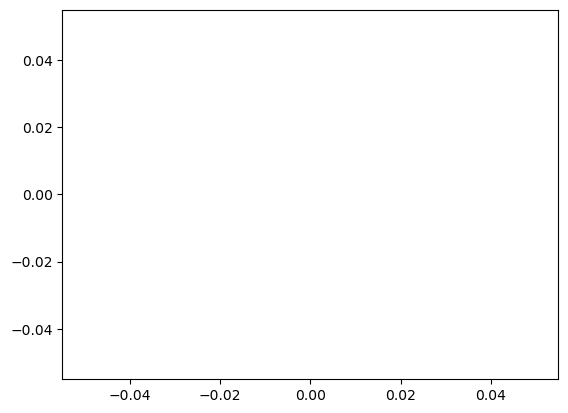

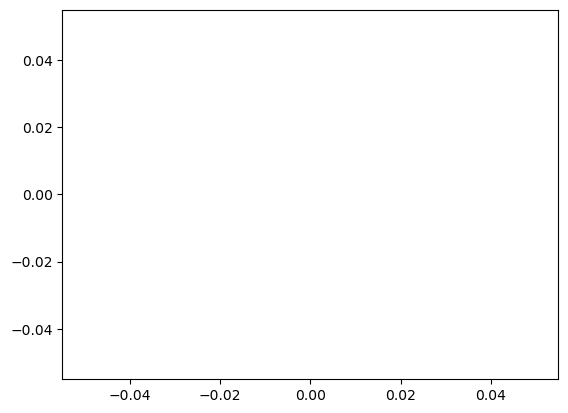

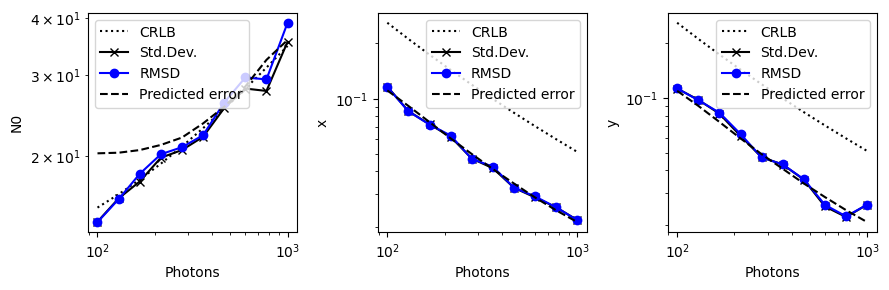

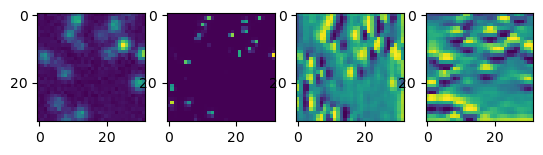

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 83 [1364/1365], Train Loss: 3.0407e+02. Test Loss: 3.0570e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 84 [1364/1365], Train Loss: 3.2897e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


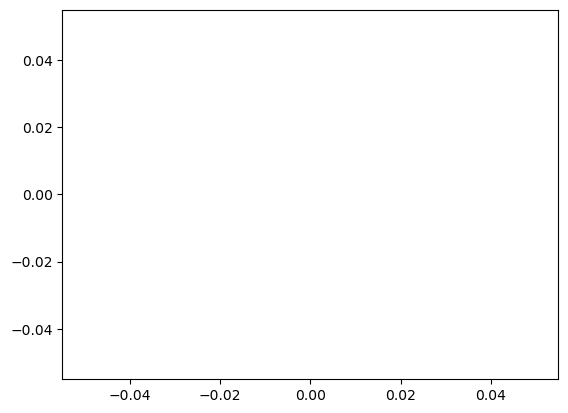

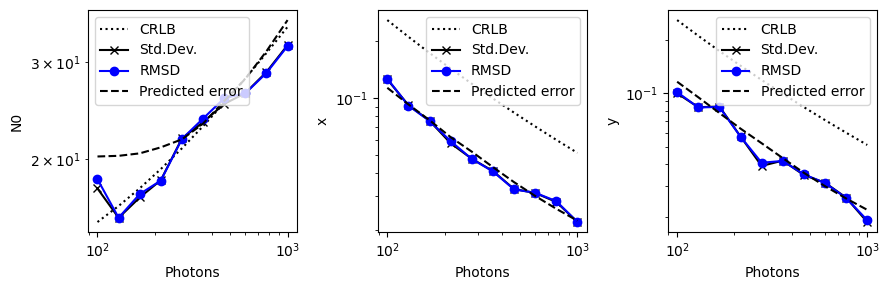

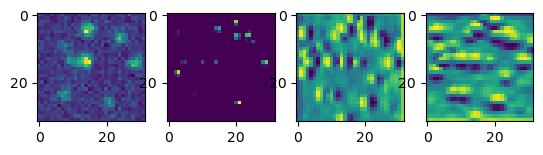

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 84 [1364/1365], Train Loss: 3.0479e+02. Test Loss: 3.0205e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 85 [1217/1365], Train Loss: 3.0706e+02:  89%|████████▉ | 1219/1365 [08:37<01:02,  2.35it/s]

kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 85 [1364/1365], Train Loss: 3.0442e+02. Test Loss: 3.0252e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 86 [1364/1365], Train Loss: 2.9232e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


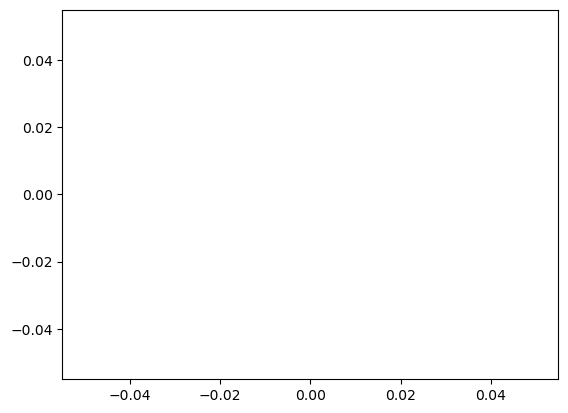

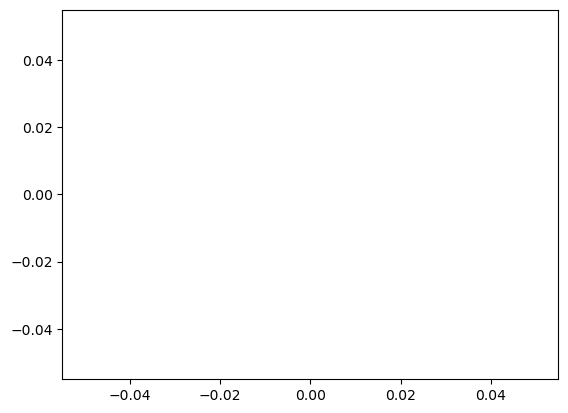

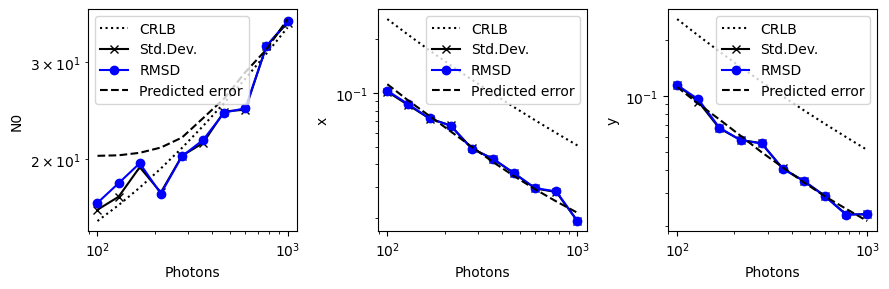

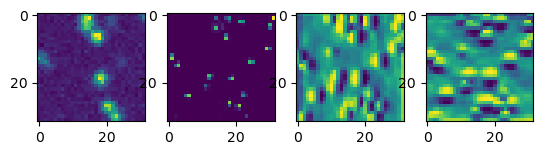

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 86 [1364/1365], Train Loss: 3.0498e+02. Test Loss: 3.0222e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 87 [1364/1365], Train Loss: 3.1339e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


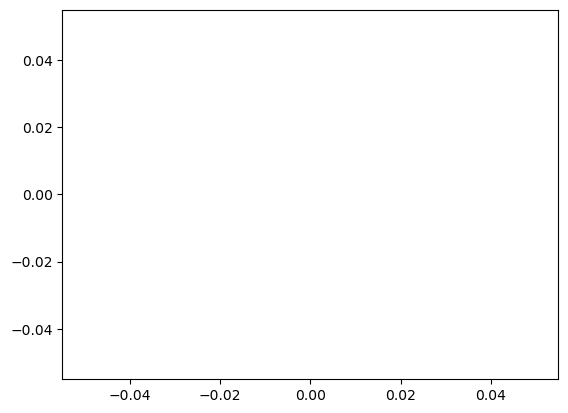

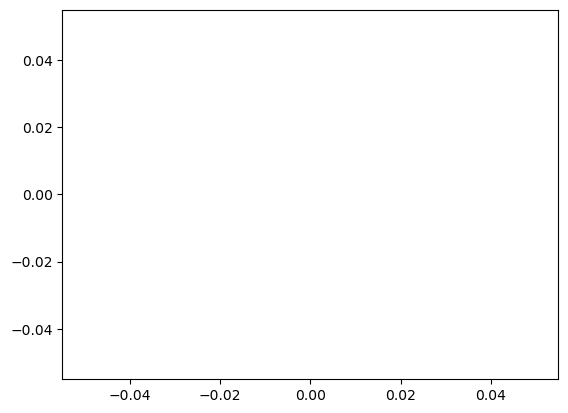

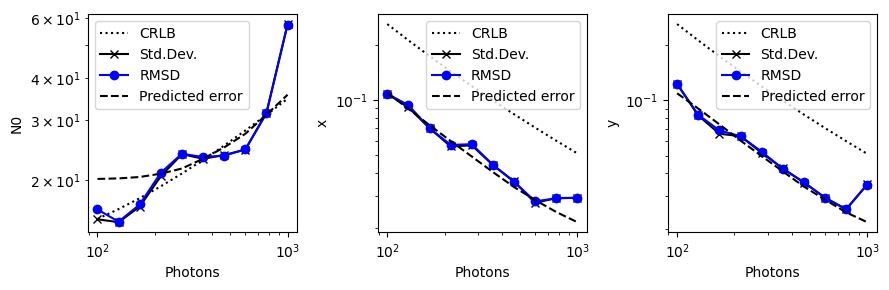

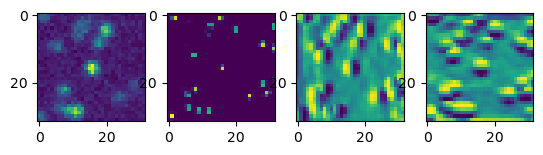

Writing benchmark info to tensorboard
Epoch 87 [1364/1365], Train Loss: 3.0393e+02. Test Loss: 3.0238e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 88 [1364/1365], Train Loss: 3.0129e+02: 100%|██████████| 1365/1365 [09:40<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


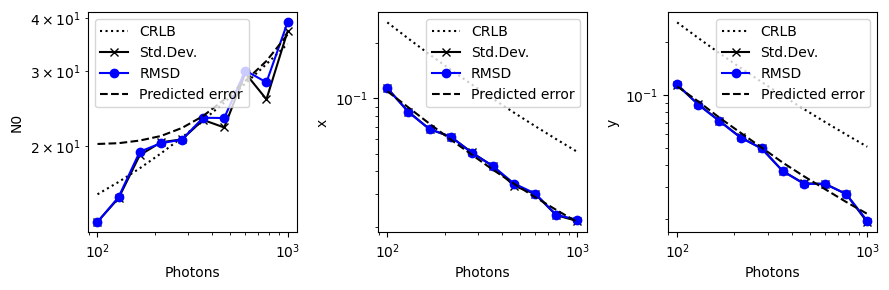

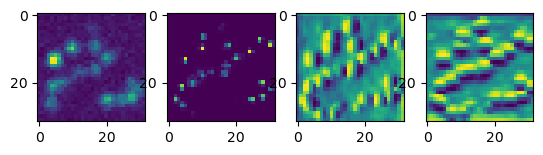

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 88 [1364/1365], Train Loss: 3.0409e+02. Test Loss: 3.0146e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 89 [1364/1365], Train Loss: 2.9792e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.35it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


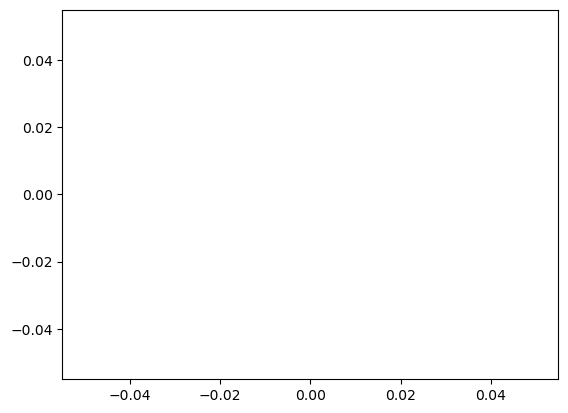

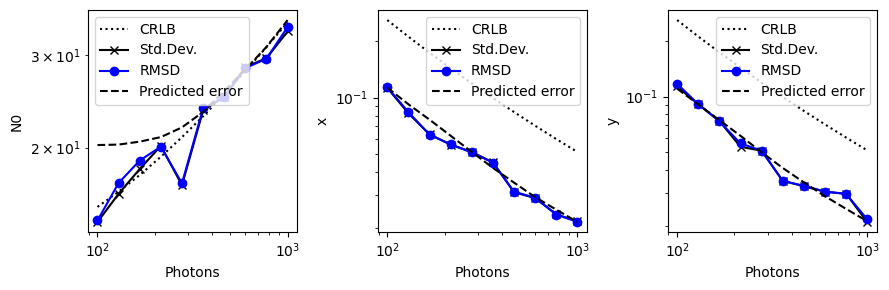

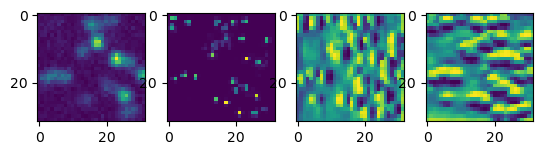

Writing benchmark info to tensorboard
Epoch 89 [1364/1365], Train Loss: 3.0410e+02. Test Loss: 3.0045e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_3.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  72%|███████▏  | 6640/9216 [00:03<00:01, 2071.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 93 [1276/1365], Train Loss: 2.8302e+02:  94%|█████████▎| 1277/1365 [09:01<00:37,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 94 [622/1365], Train Loss: 3.0153e+02:  46%|████▌     | 624/1365 [04:24<05:15,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending outpu

Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


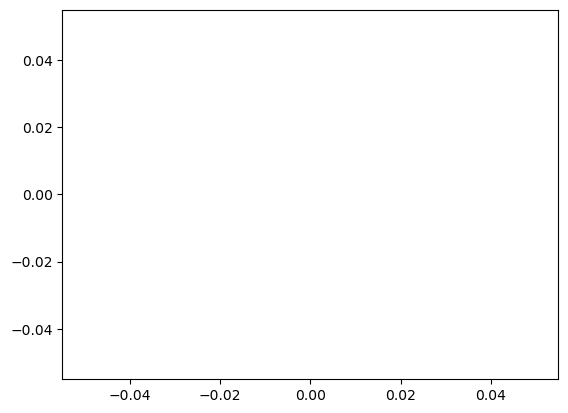

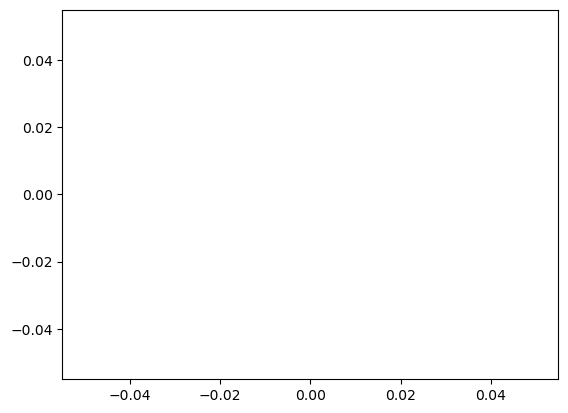

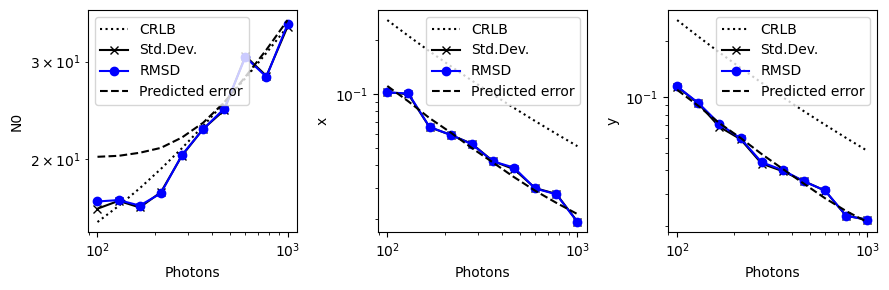

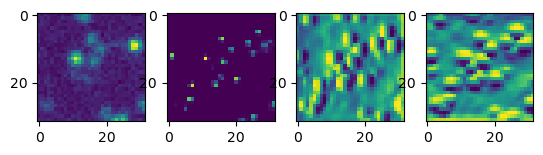

Writing benchmark info to tensorboard
Epoch 98 [1364/1365], Train Loss: 3.0272e+02. Test Loss: 2.9862e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_2.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  20%|██        | 1848/9216 [00:00<00:03, 2103.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 102 [1018/1365], Train Loss: 3.1227e+02:  75%|███████▍  | 1020/1365 [07:12<02:26,  2.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 103 [443/1365], Train Loss: 2.8166e+02:  33%|███▎      | 444/1365 [03:07<06:30,  2.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending out

Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


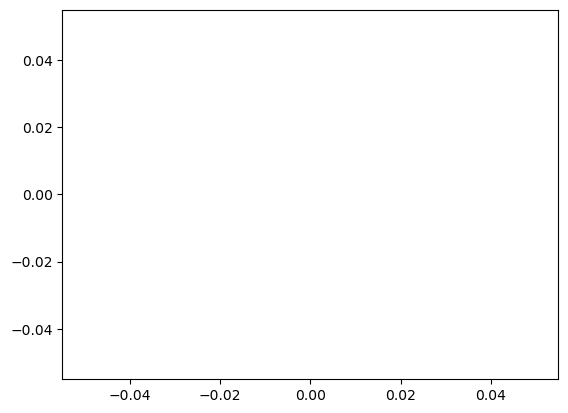

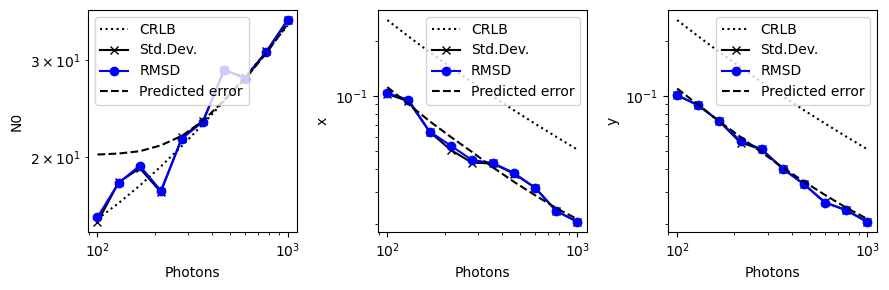

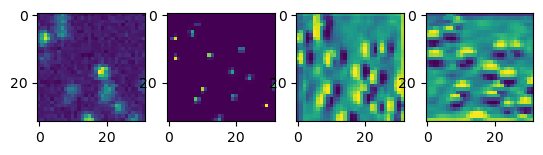

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
kde plot exception: Contour levels must be increasing
Epoch 106 [1364/1365], Train Loss: 3.0202e+02. Test Loss: 3.0072e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 107 [31/1365], Train Loss: 3.0433e+02:   2%|▏         | 33/1365 [00:13<09:14,  2.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 107 [1364/1365], Train Loss: 2.8895e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


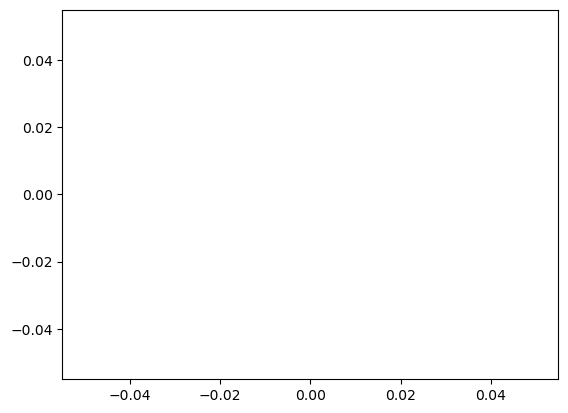

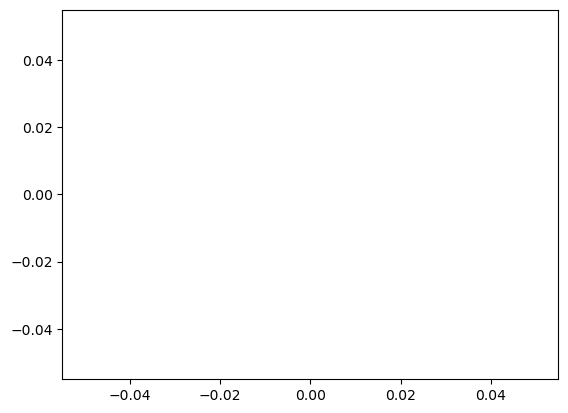

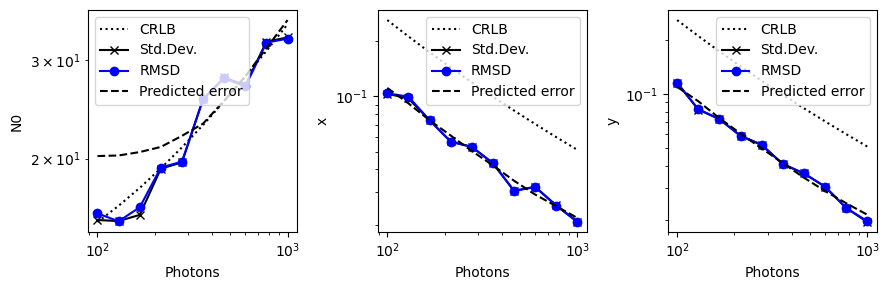

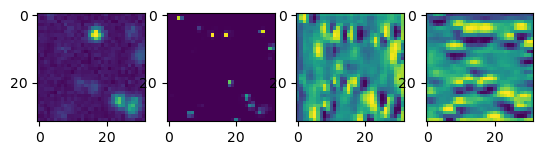

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 107 [1364/1365], Train Loss: 3.0027e+02. Test Loss: 3.0418e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  20%|█▉        | 1840/9216 [00:00<00:03, 2080.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 110 [1364/1365], Train Loss: 3.0265e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


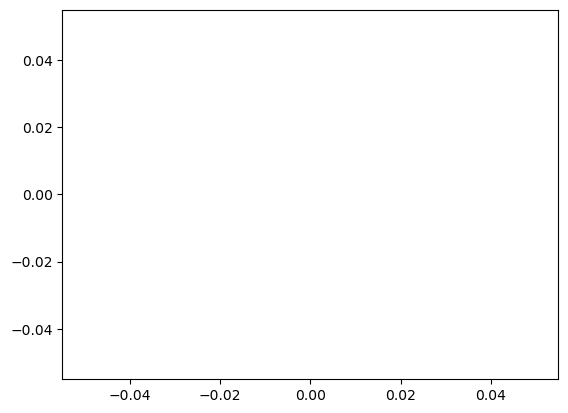

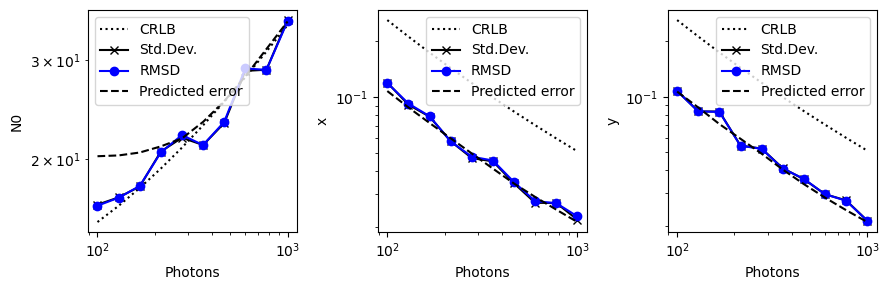

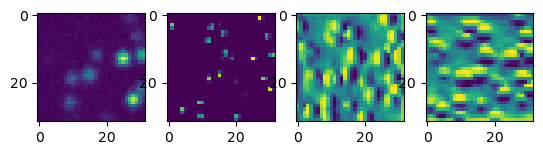

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 110 [1364/1365], Train Loss: 3.0153e+02. Test Loss: 2.9917e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_4.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Epoch 111 [21/1365], Train Loss: 2.9633e+02:   2%|▏         | 23/1365 [00:09<09:19,  2.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 111 [1364/1365], Train Loss: 3.2264e+02: 100%|██████████| 1365/1365 [09:39<00:00,  2.36it/s]


Evaluating on test dataset


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


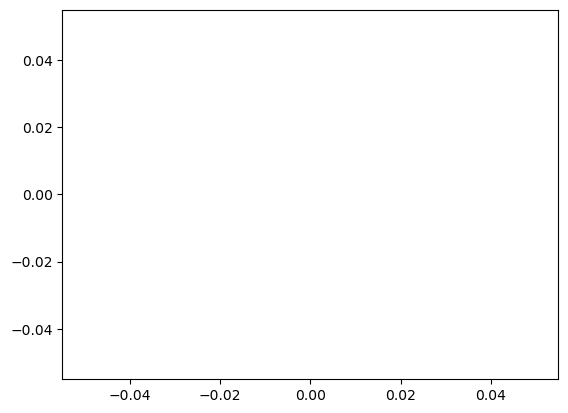

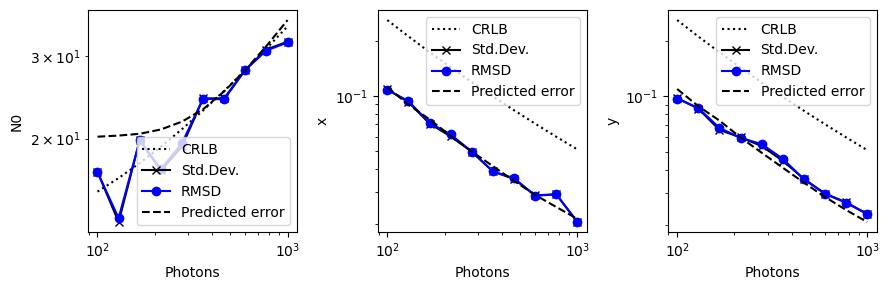

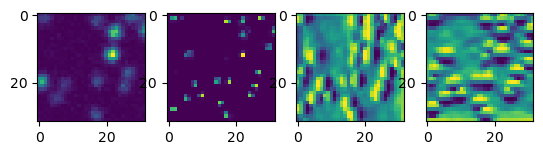

Writing benchmark info to tensorboard
kde plot exception: Contour levels must be increasing
Epoch 111 [1364/1365], Train Loss: 3.0240e+02. Test Loss: 2.9900e+02
saving checkpoint
Removed old checkpoint: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
Checkpoint saved: /home/jc/smlmtorch/scripts/models/sf_conv_g1.3_tio2_L64_2/checkpoint_0.pt
k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


Rendering frames...:  16%|█▌        | 1432/9216 [00:00<00:03, 2124.85it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 115 [997/1365], Train Loss: 3.1902e+02:  73%|███████▎  | 999/1365 [07:03<02:35,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 116 [311/1365], Train Loss: 3.3351e+02:  23%|██▎       | 313/1365 [02:12<07:27,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending outpu

KeyboardInterrupt: 

In [2]:
#%%

photon_range = np.logspace(2, 3, 10)


crlb_plotter = CRLBPlotGenerator(trainer.model, 100,
    trainer.data_generator.psf, 
    param_list=['N0', 'x', 'y'],
    psf_param_mapping = ['N', 'x', 'y'],
    sim_config=config.simulation, device=device)

def normalize(data):
    data = data.clamp_min(0)
    return data / data.view(data.shape[0], -1).max(-1)[0][:, None, None]



def cb(epoch, batch, test_output):
    #crlb_plotter.plot_photon_range(photons=photon_range, background=10, show_plot=True)
    data, camera_calib, labels = batch
    output = trainer.eval_batch(data[[0]], camera_calib[[0]])
    y = trainer.model.to_global_coords(output, revert=True)

    #print(f'output: mean {y.mean((0,1,3,4))}')
    #print(f'std {y.std((0,1,3,4))}')

    # normalize data over the last 2 dims
    batchsize, nframes, h, w = data.shape

    #crlb_plotter.plot_photon_range(photons=photon_range, background=bg_mean, show_plot=True)
    crlb_plotter.plot_photon_range(photon_range, background=bg_mean,
        n_frames=6, log_writer=trainer.writer, log_step=epoch)

    mf = config.model.num_intensities
    y = y[0,0]#config.model.lookahead_frames]
    if True:
        fig, ax=plt.subplots(1,4)
        ax[0].imshow(data[0,0].cpu().numpy())
        ax[1].imshow(y[0].cpu().numpy())
        ax[2].imshow(y[1].cpu().numpy())
        ax[3].imshow(y[2].cpu().numpy())
        plt.show() 
        plt.close()

#trainer.load_checkpoint('mf_rnn3/checkpoint_0.pt')
trainer.train(num_epochs=300, log_interval=1, batch_size = config['batch_size'],
                data_refresh_interval=1, test_callback=cb,
                report_interval=1)